# Learning to Rank using Linear Regression

## Problem:

### Tasks:
The goal of this project is to use machine learning to solve a problem that arises in Information Retrieval,
one known as the Learning to Rank (LeToR) problem. 
We have 4 subtasks to solve, which are as follows:
1. Train a linear regression model on LeToR dataset using a closed-form solution.
2. Train a linear regression model on the LeToR dataset using stochastic gradient descent (SGD).
3. Train a linear regression model on a synthetic dataset using a closed-form solution.
4. Train a linear regression model on the synthetic dataset using SGD.

### Dataset:
We have been provided with two datasets to model our supervised Machine learning algorithms, one of which is a real world dataset, while the other is generated using a mathematical formula and noise.

#### 1. The LeToR Dataset

#### 2. Synthetic Dataset


Let us begin by modelling on the real world dataset, the LeToR dataset. We will try to apply linear regression with Gaussian basis function on this data set, using two approaches:
1. Closed Form Solution
2. Stochastic Gradient Descent Solution

# LeToR Dataset

Before we start formulating the solution, we must pre-process the dataset and convert it into an appropriate form, so that we can plug the data to learn the necessary model parameters. These are the steps that we shall implement before applying the closed form approach and stochastic gradient approach on the dataset.
1. Read the dataset
2. Train-Validation-Test Split
3. Handling Non-linearity using Gaussian Basis Functions

### A. Reading Data
We have been given a text file 'Querylevelnorm.txt' containing the dataset. 
The entire dataset consists of 69623 query-document pairs(rows), each having 46 features.
Example row:

    2 qid:10032 1:0.056537 2:0.000000 3:0.666667 4:1.000000 ... 46:0.076923
    #docid = GX029-35-5894638 inc = 0.0119881192468859 prob = 0.139842

1. The first column is the output label(category) of the query, which we have to predict using our trained model. This is our independent variable y.

2. The second column qid is the query id. It is only useful for indexing the dataset and not used in regression.

3. The following 46 columns are the features. They are the 46-dimensional input vector x for our linear regression model. All the features are normalized to fall in the interval of [0, 1].

We shall read the dataset from the text file and store it into a feature matrix(size = 69623 x 46) and an output label vector(size = 69623 x 1).

In [1]:
%matplotlib inline
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [2]:
def read_data_file(filename):
    lines = [line.rstrip('\n') for line in open(filename)]
    input_matrix = []
    output_vec = []
    for line in lines:
        token_list = line.split()
        if len(token_list) == 57:
            output_vec.append(int(token_list[0]))
            input_vector = []
            for i in range(2, 48):
                token = token_list[i]
                input_vector.append(float(token.split(':')[1]))
            input_matrix.append(input_vector)

    output_vec = np.array(output_vec)
    input_matrix = np.array(input_matrix)
    return input_matrix, output_vec

In [3]:
filename = 'Querylevelnorm.txt'
feature_mat_letor, output_labels_letor = read_data_file(filename)

### B. Train - Validation - Test Split 
__Shuffle the dataset__ before we split it into training-validation-test sets. We need to shuffle the dataset randomly, so that each of the 3 sets do not have any bias with respect to any specific output label. We shall use the __numpy.random.shuffle()__ for shuffling the given dataset.

Split the feature matrix and the output vector into: Training data, Validation data, Test data, using the appropriate percentage distribution. We shall use a 80%-10%-10% split corresponding each category.
We divide the dataset as 80-10-10 where the first 80% of the dataset is the Training data, and the next 10 percents being the validation and testing data respectively. This is a rough heuristics that we consider before carrying out
our computation.

We shall train our model on the training data, and validate the output against the validation data. We will try to tune the parameters of the model, in order to minimise the error of the trained model on the validation data. 

Once we have a tuned model with lowest validation error, we shall measure the performance of our model on the test data, and that error would be reported as generalised error of our model performance.

#### Note: Never use the test data for choosing the best fit model. Keep the test dataset seperately, and use it only for reporting the final performance measures of our best model.


In [4]:
def random_shuffle_dataset(input_matrix, output_vec):
    complete_train_data = np.insert(input_matrix, 0, output_vec, axis=1)
    np.random.shuffle(complete_train_data)
    training_labels = complete_train_data[:,0]
    input_matrix = np.delete(complete_train_data,0,axis=1)
    return input_matrix, training_labels

def split_training_data(input_matrix, output_vec, train_percent, validation_percent):
    input_matrix, output_vec = random_shuffle_dataset(input_matrix, output_vec)
    training_data = []
    training_labels = []
    valid_data = []
    valid_labels = []
    test_data = []
    test_labels = []

    train_len = int(np.floor(float(train_percent) * len(input_matrix)))
    for i in range(train_len):
        training_data.append(input_matrix[i])
        training_labels.append(output_vec[i])

    validation_len = int(np.floor(validation_percent * len(input_matrix)))
    for i in range(train_len, train_len+validation_len):
        valid_data.append(input_matrix[i])
        valid_labels.append(output_vec[i])

    for i in range(train_len+validation_len, len(input_matrix)):
        test_data.append(input_matrix[i])
        test_labels.append(output_vec[i])

    return np.array(training_data), np.array(training_labels), np.array(valid_data), np.array(valid_labels), np.array(test_data), np.array(test_labels)

In [5]:
train_percent = 0.8
validation_percent = 0.1
training_data_letor, training_labels_letor, valid_data_letor, valid_labels_letor, test_data_letor, test_labels_letor = split_training_data(feature_mat_letor, output_labels_letor, train_percent, validation_percent)
print "Number of samples in Training Data: ", len(training_data_letor)
print "Number of samples in Validation Data: ", len(valid_data_letor)
print "Number of samples in Test Data: ", len(test_data_letor)

Number of samples in Training Data:  55698
Number of samples in Validation Data:  6962
Number of samples in Test Data:  6963


### C. NonLinearity to Linearity using RBFs
Construct design matrices using Gaussian Basis Functions(RBF) for the training data, validation data and the test data.

For fitting the Gaussian basis functions(RBF Kernels) on the training dataset, we need to know the following:

__1. Number of RBFs to fit__

__2. Centers of these RBF Kernels__

__3. Radius/Spread of these RBF Kernels__

The art in fitting Machine Learning models, is to find the optimum values for these parameters, which is referred to as 'Tuning the Hyper parameters'. 

Let us underline the strategy below that we shall use to apply the Gaussian Basis Functions on the training data. Real world data is not linear, and has elements of non linearity in it, which cannot be modeled using linear functions.  __We fit RBF kernels on the training data, to introduce and account for the non-linearity component in the data. From there, once we have multiple Gaussian basis functions, the task is to fit a linear model for each of these functions.__
Next we shall just follow the below steps to tune the hyperparameters, and find the optimum solutions for fitting the Gaussian functions.

#### Choosing M : Number of RBFs to fit
Number of RBF kernels determines the complexity of the model. We want to find data points which are close together, in a cluster, and fit a linear regression model over such clusters individually. The number of such clusters in the data set cannot be determined exactly, and we shall use an iterative method for determining this parameter M(num_basis).

#### Choosing  µj : Choosing the centers of RBF Kernels
   
   ##### K-Means Clustering algorithm
        a. For searching the clusters in dataset, we shall use the __K-Means Clustering algorithm__, which forms K clusters of given data points when we specify the input K. 

        b. It is a fast unsupervised algorithm, which assigns K random data points as centres of K clusters, and iteratively computes distance of each data point in the training set to each of these centres, and maps each data point to one of these centres based on the least square distance criteria. 

        c. The centre moves in each iteration, towards the centre of the cluster, until convergence and we have K clusters and K centres.

        d. In our case, we shall cluster the data into M clusters, equivalent to the number of RBF kernels we are using in the iteration. 

        e. The clustering will return M centres of the clusters, which shall represent our µj. Note that µj is a data point from the training set, and hence is a vector of 46-dimension.

#### Choosing  Σ : Radius/Spread of Gaussian Kernels
    The variance of each column of the training data set i.e across each dimension of the data point shall denote the spread/radius of our gaussian basis function.  
        Σ = [variance1      0         0      .......      0
                 0      variance2     0      .......      0 
                            0      variance3 .......
                                             .......  variance46]
       where varianceJ = variance of jth column of dataset
       Hence Σ is a 46 x 46 diagonal matrix of variances.

#### Computing the Design Matrix ϕ
    Using these values of µj and Σ, we can now fit the RBF kernels on our data. We have all the necessary values for computing the design matrix(ϕ).
        ϕj (x) = exp (−0.5* transpose(x − µj)* inverse(Σj) *(x − µj))
        
        Φ = [Φ0(x1)   ϕ1(x1)   ϕ2(x1) · · ·  ϕM−1(x1)
             Φ0(x2)   ϕ1(x2)   ϕ2(x2) · · ·  ϕM−1(x2)
             .
             .
             .
             .
             Φ0(xN)   ϕ1(xN)   ϕ2(xN) · · ·  ϕM−1(xN)]           
       where M are the RBF Kernels and x1, x2.... xN are points from the training set.

In [6]:
def k_means_clusters(train_data, training_labels, num_basis):
    kmeans = KMeans(n_clusters=num_basis, random_state=0).fit(train_data)
    labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    clusters = {}
    for i in range(num_basis):
        clusters[i] = {'train_data':[], 'output' : [], 'center' : cluster_centers[i]}

        for j in range(len(train_data)):
            if labels[j] == i:
                clusters[i]['train_data'].append(train_data[j])
                clusters[i]['output'].append(training_labels[j])
    return cluster_centers

In [7]:
def create_design_matrix_train_data(train_data, training_labels, lamda, num_basis):
    variance = train_data.var(axis=0) 
    sigma = variance * np.identity(len(train_data[0]))
    sigma = sigma + 0.001 * np.identity(len(train_data[0])) # Add a small quantity to avoid 0 values in variance matrix.
    sigma_inv = np.linalg.inv(sigma)

    rand_centers = k_means_clusters(train_data, training_labels, num_basis)
    rand_centers = np.array(rand_centers)
    design_matrix=np.zeros((len(train_data),num_basis));

    for i in range(len(train_data)):
        for j in range(num_basis):
            if j==0:
                design_matrix[i][j] = 1;
            else:
                x_mu = train_data[i]-rand_centers[j]
                x_mu_trans = x_mu.transpose()
                temp1 = np.dot(sigma_inv, x_mu_trans)
                temp2 = np.dot(x_mu, temp1)
                design_matrix[i][j] = np.exp(((-0.5)*temp2))
                
    return design_matrix, sigma_inv, rand_centers

In [8]:
def create_design_matrix_data(data, sigma_inv, rand_centers, num_basis):
    design_matrix = np.zeros((len(data),num_basis))
    for i in range(len(data)):
        for j in range(num_basis):
            if j==0:
                design_matrix[i][j] = 1;
            else:
                x_mu = data[i] - rand_centers[j]
                x_mu_trans = x_mu.transpose()
                temp1_valid = np.dot(sigma_inv, x_mu_trans)
                temp2_valid = np.dot(x_mu, temp1_valid)
                design_matrix[i][j] = np.exp(((-0.5) * temp2_valid))
    return design_matrix

In [9]:
def calculate_error(input_matrix, weights, output_vec):
    predicted_output = np.dot(weights, input_matrix.transpose())
    sq_error_sum = np.sum(np.square(output_vec - predicted_output))
    error = np.sqrt(float(sq_error_sum)/len(output_vec))
    return error

For plotting the data, we have written a function below, which plots the Training RMSE, Validation set RMSE agains the model complexity.

In [10]:
def plot_data(y_values1, y_values2, lamda, label1, label2, axis_dim):
    plt.plot(y_values1, 'ro',label=label1)
    plt.plot(y_values2, 'b-', label = label2)
    plt.axis(axis_dim)
    plt.ylabel('RMSE')
    plt.xlabel('Model Complexity')
    plt.title('Lambda = ' + str(lamda))
    l = plt.legend()
    plt.show()

### Regularization Parameter (λ):
The λ parameter is the regularisation parameter, and we can tune it by trying out different values for λ. It basically tries to create a sparse solution, by eliminating features which do not have much contribution to the linear regression model. 
    We try multiple linear regression models with iterative values of λ and M (no. of basis functions). For λ, which has to be between 0 and 1, we start with a small value 0.001 and increase it logarithmically, testing for λ in [0.001, 0.01, 0.1, 0.5, 1]

### 1. Train a linear regression model on LeToR dataset using a closed-form solution
### Closed Form Solution:
i. Next for closed form solution, we compute the weights for given training data and set hyper parameters using the formula:

        w∗ = inv((λI + transpose(Φ) * Φ))* transpose(Φ)*y   
        where I is identity matrix;
        Φ is the design matrix of training data representation in M dimensions using RBF Kernels

ii. These values of weights determine the contribution of each Gaussian Basis Function(RBF) in our linear regression model trained on the entire training data.

iii. We predict the output labels using these weights and the design matrix Φ, to determine how erronous is the prediction of our model from the actual label.
            y(x, w) = transpose(w*) * ϕ(x)
iv. We determine the error in predictions using Root Mean Squared Error(RMSE), which is infact the square root of sum of squared errors of our model predictions on each data point in the training set.

v. Next, we have to test this model with the set λ and M values on the validation set. For this, we use the same µj and Σ values, to convert the 46 dimensional data to M dimensional validation set.

vi. We use the same steps, as for training data, to compute the predictions on the validation set and calculate the RMSE on the validation set.

vii. We repeat all the above steps for different values of number of basis functions M and regularisation parameter λ, and store the training RMSE and validation RMSE for each combination.

viii. We pick the model which has LEAST RMSE ON VALIDATION SET as our final solution, and store the values of M, λ and weights w*. 

In [11]:
def closed_form_solution_training_phase(design_matrix, sigma_inv, training_labels, lamda, num_basis):
    design_matrix_trans = design_matrix.transpose()
    regularisation_mat = lamda * np.identity(num_basis)
    pinv_temp = np.dot(design_matrix_trans, design_matrix) + regularisation_mat
    pinv = np.linalg.inv(pinv_temp)
    out_temp = np.dot(design_matrix_trans, training_labels)
    weights = np.dot(pinv, out_temp)
    train_error = calculate_error(design_matrix, weights, training_labels)
    return weights, train_error

As discussed above, we shall iteratively choose value of the regularisation parameter(λ) and the number of basis functions. For each value of (λ, M) we shall train our model using the closed form solution, and store the model performance parameters such as RMSE train and RMSE Validation, corresponding to these parameters.

__ Note: For choosing the optimum model, we shall choose the model which performs best on the VALIDATION SET and not on the training set. Hence, choose the trained model which has the least RMSE Validation value.__

In [12]:
lamda_values = [0.001, 0.01, 0.1, 0.5, 1]
error_matrix_letor = {'closed_form':{'train':{}, 'validation':{}}, 'sgd': {'train':{}, 'validation':{}}}
for lamda in lamda_values:
    print "λ = ", lamda
    error_matrix_letor['closed_form']['train'][lamda] = []
    error_matrix_letor['closed_form']['validation'][lamda] = []
    for num_basis in range(1, 31):
        design_matrix_train_letor, sigma_inv_letor, rbf_centers_letor = create_design_matrix_train_data(training_data_letor, training_labels_letor, lamda, num_basis)
        weights_letor, rmse_train_letor = closed_form_solution_training_phase(design_matrix_train_letor, sigma_inv_letor, training_labels_letor, lamda, num_basis)
        design_matrix_validation_letor = create_design_matrix_data(valid_data_letor, sigma_inv_letor, rbf_centers_letor, num_basis)
        rmse_validation_letor = calculate_error(design_matrix_validation_letor, weights_letor, valid_labels_letor)
        error_matrix_letor['closed_form']['train'][lamda].append(rmse_train_letor)
        error_matrix_letor['closed_form']['validation'][lamda].append(rmse_validation_letor)

λ =  0.001
λ =  0.01
λ =  0.1
λ =  0.5
λ =  1


We have stored the model performance corresponding to each trained model, with unique combination of (M, λ) in the error_matrix_letor['closed_form'] dictionary.

We shall now plot the model performance parameters, and shall study how the performance changes as the model complexity increases for different values of regularisation parameter.
This will enable us to choose the best trained model which fits the given LeToR dataset optimally.

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.001


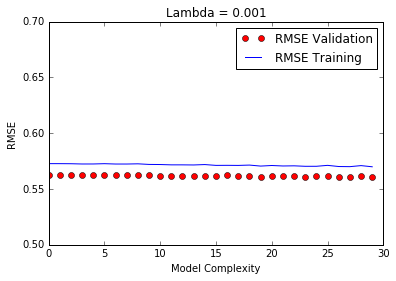

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.01


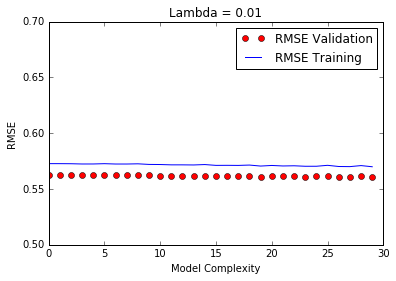

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.1


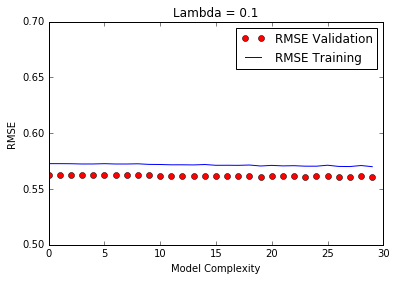

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.5


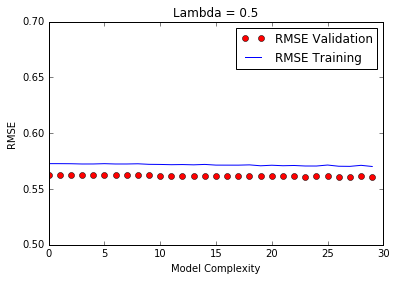

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  1


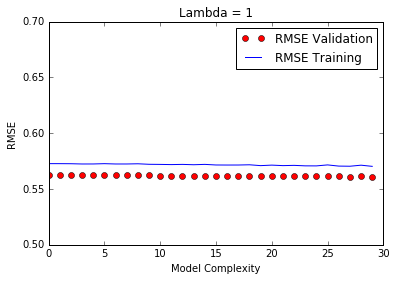

In [14]:
for lamda in sorted(error_matrix_letor['closed_form']['train']):
    print "Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ = ", lamda
    plot_data(error_matrix_letor['closed_form']['validation'][lamda],error_matrix_letor['closed_form']['train'][lamda], lamda, 'RMSE Validation', 'RMSE Training', [0, 30, 0.5, 0.7])

Let us inspect all the values of RMSE Training(Erms,t) and RMSE Validation(Erms,v) for different values of regularisation parameter and number of basis functions M.

__Note that, we shall choose the model as the best fit, which has least RMSE Validation(Erms,v). As stated earlier, the test dataset has been secluded until this spot, and we shall only calculate the final model performnace on it.__

RMSE Training for different values of λ(column headers) and Number of basis Functions(row headers)


,0.001,0.01,0.1,0.5,1.0
1,0.572728,0.572728,0.572728,0.572728,0.572728
2,0.572715,0.572715,0.572715,0.572715,0.572715
3,0.572651,0.572651,0.572651,0.572652,0.572652
4,0.572412,0.572412,0.572412,0.572413,0.572416
5,0.572426,0.572427,0.572428,0.572429,0.572431
6,0.572687,0.572690,0.572694,0.572700,0.572704
7,0.572382,0.572389,0.572401,0.572413,0.572418
8,0.572376,0.572383,0.572402,0.572415,0.572420
9,0.572564,0.572571,0.572588,0.572597,0.572600
10,0.572018,0.572022,0.572048,0.572106,0.572140


RMSE Validation for different values of λ(column headers) and Number of basis Functions(row headers)


,0.001,0.01,0.1,0.5,1.0
1,0.562496,0.562496,0.562496,0.562496,0.562495
2,0.562509,0.562509,0.562508,0.562507,0.562506
3,0.562437,0.562434,0.562431,0.562430,0.562430
4,0.562251,0.562251,0.562250,0.562247,0.562245
5,0.562275,0.562267,0.562264,0.562258,0.562255
6,0.562569,0.562555,0.562541,0.562529,0.562525
7,0.562309,0.562290,0.562275,0.562270,0.562268
8,0.562296,0.562287,0.562279,0.562272,0.562269
9,0.562414,0.562408,0.562409,0.562408,0.562407
10,0.562115,0.562131,0.562178,0.562222,0.562231


### After reviewing the RMSE Validation for different values of M and λ, and from the plots above, we can see that the training model with M = 30 and λ = 0.01, has the best performance for fitting the given LeToR dataset and has the least RMSE on Validation set = 0.5608

### Hence, this is the model and the parameters that we shall choose as our solution. Let us print the performance metrics of the model and the final weights of the trained model.

__Now let us go ahead and measure the model performance on TEST DATA SET. The RMSE on Test set shall be reported as the performance of our linear regression model.__

In [26]:
lamda = 0.01
num_basis = 30
design_matrix_train_cf, sigma_inv_cf, rbf_centers_cf = create_design_matrix_train_data(training_data_letor,training_labels_letor, lamda, num_basis)
weights_cf, rmse_train_cf = closed_form_solution_training_phase(design_matrix_train_cf, sigma_inv_cf, training_labels_letor, lamda, num_basis)
design_matrix_validation_cf = create_design_matrix_data(valid_data_letor, sigma_inv_cf, rbf_centers_cf, num_basis)
rmse_validation_cf = calculate_error(design_matrix_validation_cf, weights_cf, valid_labels_letor)
design_matrix_test_cf = create_design_matrix_data(test_data_letor, sigma_inv_cf, rbf_centers_cf, num_basis)
rmse_test_cf = calculate_error(design_matrix_test_cf,weights_cf, test_labels_letor)

In [27]:
print "Best fit Linear Regression Model using Closed Form Solution Performance: "
print "\n"
print "RMSE on Training Set: ", rmse_train_cf 
print "\n"
print "RMSE on Validation Set: ", rmse_validation_cf
print "\n"
print "RMSE on Test Set: ", rmse_train_cf
print "\n"
print "Weights Vector(w) for the trained Model:\n", weights_cf

Best fit Linear Regression Model using Closed Form Solution Performance: 


RMSE on Training Set:  0.569938986664


RMSE on Validation Set:  0.560762760486


RMSE on Test Set:  0.569938986664


Weights Vector(w) for the trained Model:
[  3.22484555e-01   2.33847690e+00   2.34207711e+00   3.60933571e-01
   4.65657983e-01  -1.41762410e-01  -1.85777943e+00   4.96814116e+00
  -4.73638524e-04   6.01505171e-02  -1.59423514e+00  -2.16056740e+00
  -3.85282512e+00   4.21781158e+00  -9.75698199e-01  -4.51014239e-01
   4.75969511e+00  -1.16859553e+00  -1.18269368e+00   7.56397164e-02
   9.25042774e-01  -2.44502195e+00   1.97463906e+00  -1.09180585e+00
   9.47779068e-01  -5.52140059e-01  -4.22417499e-02  -2.96774416e+00
   2.19454341e+00  -7.66518374e+00]


### As we see, the Root Mean Square Error of our trained linear regression model using Closed Form Solution and Gaussian Basis Functions on test set is 0.5699, for M = 30  and λ = 0.01.


Now let us try finding the solution to the same LeToR dataset, but this time, we shall be using Stochastic Gradient Descent Algorithm, for finding the weight vector(w) which give us the minimum RMSE value on Validation set.

### 2. Train a linear regression model on the LeToR dataset using stochastic gradient descent (SGD)
### Stochastic Gradient Descent:
i. For stochastic gradient descent, we compute the weights vector w* iteratively, updating its value after analysing each data point in the training set.

ii. Begin by randomly initialising vector w*. It is a vector of size (M x 1), where M is the number of Gaussian Basis Functions.

iii. The weights are updated for each data point using the formula:

            w(τ+1) = w(τ) + ∆w(τ)
            where ∆w(τ) = −η(τ)* ∇E is called the weight updates. 
            It goes along the opposite direction of the gradient of the error.
            η(τ) is the learning rate at iteration τ. It decides how big each update step should be.

iv. ∇E is the derivative of our cost function, and it determines the change in cost at a particular iteration, given the weights we used to compute the cost. Since our cost function comprises of two linearly differentiable terms, the cost function and the regularisation term, we can write:
            
            ∇E = ∇Ed + λ*∇Ew
            
            where ∇Ed = −(yi − transpose(w(τ))* ϕ(xi))* ϕ(xi)
            
              and ∇Ew = w(τ)

v. Updated weights can be written as:

            w(τ+1) = w(τ) + η(τ) * ((yi − transpose (w(τ)) * ϕ(xi))*ϕ(xi) - λ * w(τ))

vi. For set values of (η,λ,M), we take a single datapoint, compute values of ∇Ed, ∇Ew and determine updated weights for next iteration. 

vii. As for closed form solution, we use the obtained values of weights to compute the predicted labels for each data point in training design matrix. We predict the output labels using these weights and the design matrix Φ, to determine how erronous is the prediction of our model from the actual label.

            y(x, w) = transpose(w*) * ϕ(x)
            
viii. We determine the error in predictions using Root Mean Squared Error(RMSE), which is infact the square root of sum of squared errors of our model predictions on each data point in the training set.
      
ix. __Shuffling the training data for multiple passes__ - Several passes can be made over the training set until the algorithm converges. If this is done, the data can be shuffled for each pass to prevent cycles. We have implemented this approach in our implementation of the SGD and hence have shuffled the data using __numpy.random.shuffle()__ 
     
x. When there is very less change in the value of training error, we say that the model has converged, and we store these values of weights(w*) and regularisation parameter(λ) corresponding to the chosen number of basis functions. 
    
xi. Next, we have to test this model with the set λ and M values on the validation set. For this, we use the same µj and Σ values, to convert the 46 dimensional data to M dimensional validation set.
   
xii. We use the same steps, as for training data, to compute the predictions on the validation set and calculate the RMSE on the validation set.
    
xiii. We repeat all the above steps for different values of number of basis functions M and regularisation parameter λ, and store the training RMSE and validation RMSE for each combination.
     
xiv. We pick the model which has LEAST RMSE ON VALIDATION SET as our final solution, and store the values of M, λ and weights w*.            

Let us talk a little about how we choose our learning rate for stochastic gradient descent.
### Learning Rate/ Momentum(η):
       1. We can either fix the values of η, for training the entire model. But there are two situations where we could face difficulties:
             a. If η is too small, the model will take a lot of time before it converges.
             b. If η is too large, the model might skip a lot of steps and will be fast, but we risk missing out on the global minima.
       2. As a result of this, we can keep use an adaptive learning rate η. 
             a. If the model is moving towards optimum solution, we should be more cautious and take smaller steps towards the minima, hence decrease the value of η if we rae moving in right direction.
             b. But, if the model is still pretty far away from the minima, we need to speed up the process to reach minima in an efficient manner, hence we boost the value of η.

This approach ensures that we choose just the right learning rate at each iteration in the Stochastic Gradient Descent.

In [12]:
def stochastic_gradient_solution(design_matrix_train, training_labels, lamda, num_basis):
    n = 1
    boost_factor = 1.25
    degrade_factor = 0.8
    del_error = 100000
    weights = np.random.uniform(-1.0,1.0,size=(1,num_basis))[0]
    eta1 = []
    error_iteration = []
    num_iter = 0
    # We shall choose a small value for change in the relative error between two passes 
    # as the termination condition, but sometimes the model performs additional unnecessary passes 
    # before achieving this small error change. Hence we prune the number of passes and allow the model
    # to make constant passes, as additional passes don't lead to any significant gain.
    while del_error > 0.00001 and num_iter < 5:
        complete_train_data = np.insert(design_matrix_train, 0, training_labels, axis=1)
        np.random.shuffle(complete_train_data)
        training_labels = complete_train_data[:,0]
        design_matrix_train = np.delete(complete_train_data,0,axis=1)
        for i in range(len(training_labels)):
            error_iteration.append(calculate_error(design_matrix_train, weights, training_labels))
            temp1 = training_labels[i] - np.dot(weights, design_matrix_train[i,:].transpose())
            temp2 = -1 * temp1 * design_matrix_train[i,:]
            temp3 = temp2 + lamda * weights
            eta1.append(n)
            new_weights = weights - n * temp3
            new_weight_vec = np.sum(np.square(new_weights))
            old_weight_vec = np.sum(np.square(weights))
            if np.sqrt(np.abs(new_weight_vec - old_weight_vec)) < 0.0001:
                n = n * boost_factor
            else:
                n = n * degrade_factor
            weights = new_weights
        train_error = calculate_error(design_matrix_train, weights, training_labels)
        if num_iter == 0:
            init_error = train_error
            del_error = 100000
        else:
            del_error = init_error - train_error
            init_error = train_error
        num_iter +=1
    return weights, train_error, eta1, error_iteration

In [ ]:
lamda_values = [0.001, 0.01, 0.1, 0.5, 1]
for lamda in lamda_values:
    print "λ = ", lamda
    error_matrix_letor['sgd']['train'][lamda] = []
    error_matrix_letor['sgd']['validation'][lamda] = []
    for num_basis in range(1, 31):
        design_matrix_train_letor, sigma_inv_letor, rbf_centers_letor = create_design_matrix_train_data(training_data_letor, training_labels_letor, lamda, num_basis)
        weights_letor, rmse_train_letor, learning_rate_changes, error_iteration = stochastic_gradient_solution(design_matrix_train_letor, training_labels_letor, lamda, num_basis)
        design_matrix_validation_letor = create_design_matrix_data(valid_data_letor, sigma_inv_letor, rbf_centers_letor, num_basis)
        rmse_validation_letor = calculate_error(design_matrix_validation_letor, weights_letor, valid_labels_letor)
        error_matrix_letor['sgd']['train'][lamda].append(rmse_train_letor)
        error_matrix_letor['sgd']['validation'][lamda].append(rmse_validation_letor)

We have stored the model performance corresponding to each trained model, with unique combination of (M, λ) in the error_matrix_letor['sgd'] dictionary.

We shall now plot the model performance parameters, and shall study how the performance changes as the model complexity increases for different values of regularisation parameter.
This will enable us to choose the best trained model which fits the given LeToR dataset optimally.

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.001


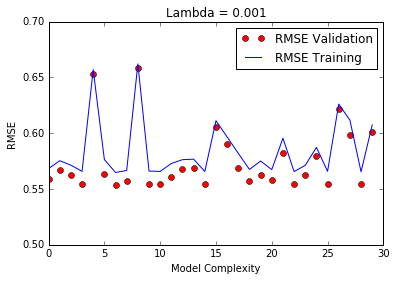

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.01


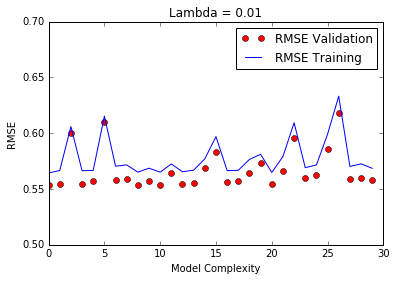

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.1


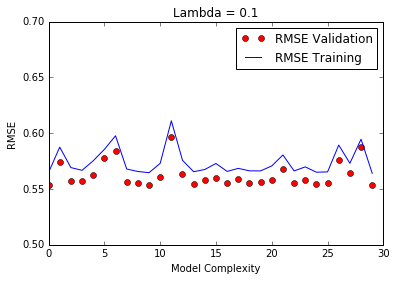

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.5


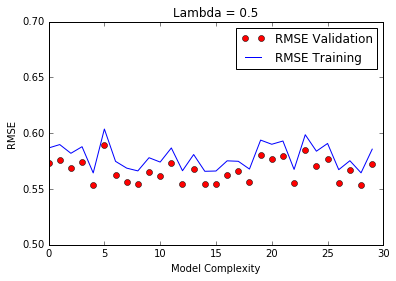

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  1


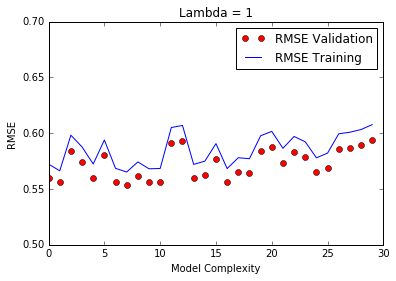

In [183]:
for lamda in sorted(error_matrix_letor['sgd']['train']):
    print "Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ = ", lamda
    plot_data(error_matrix_letor['sgd']['validation'][lamda],error_matrix_letor['sgd']['train'][lamda], lamda, 'RMSE Validation', 'RMSE Training', [0, 30, 0.5, 0.7])

Let us inspect all the values of RMSE Training(Erms,t) and RMSE Validation(Erms,v) for different values of regularisation parameter and number of basis functions M.

__Note that, we shall choose the model as the best fit, which has least RMSE Validation(Erms,v). As stated earlier, the test dataset has been secluded until this spot, and we shall only calculate the final model performnace on it.__

RMSE Training for different values of λ(column headers) and Number of basis Functions(row headers)


,0.001,0.01,0.1,0.5,1.0
1,0.568257,0.564396,0.564880,0.586753,0.572349
2,0.575335,0.566514,0.587518,0.589804,0.566296
3,0.571363,0.605919,0.569169,0.581993,0.598220
4,0.565778,0.566391,0.566765,0.587894,0.587675
5,0.656941,0.566674,0.575257,0.564397,0.572389
6,0.576383,0.615376,0.585504,0.603743,0.593890
7,0.564801,0.570450,0.597666,0.574781,0.568502
8,0.566629,0.571601,0.567917,0.568699,0.565227
9,0.662110,0.565101,0.565692,0.566225,0.574254
10,0.566075,0.568635,0.564606,0.578041,0.568120


RMSE Validation for different values of λ(column headers) and Number of basis Functions(row headers)


,0.001,0.01,0.1,0.5,1.0
1,0.558860,0.553691,0.553702,0.573455,0.559956
2,0.566818,0.554675,0.574189,0.576396,0.556487
3,0.562426,0.599869,0.557043,0.568923,0.584493
4,0.554490,0.554668,0.556986,0.574543,0.574336
5,0.653141,0.556870,0.562546,0.553625,0.559993
6,0.563655,0.610132,0.578225,0.589858,0.580307
7,0.553705,0.558145,0.584055,0.562168,0.556538
8,0.556810,0.559154,0.555941,0.556710,0.553911
9,0.658531,0.554008,0.555694,0.554667,0.561696
10,0.554734,0.556852,0.553748,0.565201,0.556210


### After reviewing the RMSE Validation for different values of M and λ, and from the plots above, we can see that the training model with M = 11 and λ = 0.01, has the best performance for fitting the given LeToR dataset using Stochastic Gradient Descent and has the least RMSE on Validation set = 0.5545

### Hence, this is the model and the parameters that we shall choose as our solution. Let us print the performance metrics of the model and the final weights of the trained model.

__Now let us go ahead and measure the model performance on TEST DATA SET. The RMSE on Test set shall be reported as the performance of our linear regression model using Stochastic Gradient Descent on LeToR Dataset.__

In [191]:
lamda = 0.01
num_basis = 11
design_matrix_train_sgd, sigma_inv_sgd, rbf_centers_sgd = create_design_matrix_train_data(training_data_letor, training_labels_letor, lamda, num_basis)
weights_sgd, rmse_train_sgd, learning_rate_changes_sgd, error_iteration_letor_sgd = stochastic_gradient_solution(design_matrix_train_sgd, training_labels_letor, lamda, num_basis)
design_matrix_validation_sgd = create_design_matrix_data(valid_data_letor, sigma_inv_sgd, rbf_centers_sgd, num_basis)
rmse_validation_sgd = calculate_error(design_matrix_validation_sgd, weights_sgd, valid_labels_letor)
design_matrix_test_sgd = create_design_matrix_data(test_data_letor, sigma_inv_sgd, rbf_centers_sgd, num_basis)
rmse_test_sgd = calculate_error(design_matrix_test_sgd, weights_sgd, test_labels_letor)

In [187]:
print "Best fit Linear Regression Model using Stochastic Gradient Descent(SGD) Performance Metrics: "
print "\n"
print "RMSE on Training Set: ", rmse_train_sgd 
print "\n"
print "RMSE on Validation Set: ", rmse_validation_sgd
print "\n"
print "RMSE on Test Set: ", rmse_test_sgd
print "\n"
print "Weights Vector(w) for the trained Model:\n", weights_sgd

Best fit Linear Regression Model using Stochastic Gradient Descent(SGD) Performance Metrics: 


RMSE on Training Set:  0.564856084394


RMSE on Validation Set:  0.554452578362


RMSE on Test Set:  0.637591911743


Weights Vector(w) for the trained Model:
[ 0.32662874  0.20491318 -0.36197948 -0.69389639 -0.0833514  -0.82821713
  0.85042275 -0.12771575 -0.3891245   0.32196762  0.6844154 ]


### As we see, the Root Mean Square Error of our trained linear regression model using Stochastic Gradient Descent Algorithm and Gaussian Basis Functions on test set is 0.6376, for M = 11  and λ = 0.01.


Now, as the last step of the solution, let us verify the hypothesis we stated regarding the Learning rate(η). 

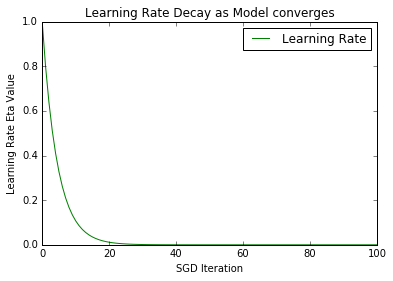

In [82]:
plt.plot(learning_rate_changes_sgd, 'g-', label='Learning Rate')
plt.axis([0, 100, 0, 1])
plt.ylabel('Learning Rate Eta Value')
plt.xlabel('SGD Iteration')
plt.title('Learning Rate Decay as Model converges')
l = plt.legend()
plt.show()

##### We had stated that for choosing the learning rate, we shall begin with η=1, and let the learning rate be adaptive. 
##### As the iterations over different datapoints in the training set go on, the η value adjusts itself, so as to not overshoot the optimal solution(minima in the cost function of SGD) by decreasing the value as the weights approach towards the solution.

##### As can be verified from the Learning rate plot, its a decay plot and the learning rate(η) keeps on decreasing as the iterations proceed and we move closer towards the optimal solution.

Let us also plot the Training error as the number of iterations of the SGD algorithm increase. 

The intuition as we have learnt for Stochastic Gradient Descent Algorithm is that, initially the training error would be high and will have drastic fluctuations, as the algorithm is making predicions based on a few datapoints it has seen. 

As the iterations increase, the model becomes more robust and the rate of change of error reduces.

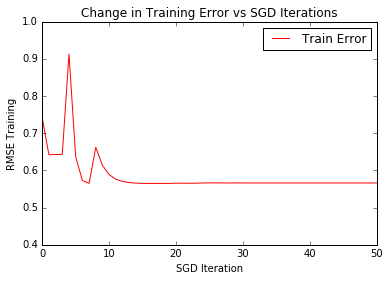

In [201]:
plt.plot(error_iteration_letor_sgd, 'r-', label='Train Error')
plt.axis([0, 50, 0.4, 1])
plt.ylabel('RMSE Training')
plt.xlabel('SGD Iteration')
plt.title('Change in Training Error vs SGD Iterations')
l = plt.legend()
plt.show()

__As expected, the train error keeps decreasing as the number of iterations of SGD increase. Also notice the fluctuations at the beginning of the model training, and robustness later on.__

Now let us apply the closed form algorithm and the Stochastic Gradient Descent(SGD) algorithm to train a linear regression model on synthetic dataset.
## 3. Train a linear regression model on a synthetic dataset using a closed-form solution
## Synthetic Dataset

Here we use the same approach as done in the real world dataset. We import the data in the correct format. Create the features matrix and apply the formulas as above.

Here again we try to find the best combination of the M and lambda. 

This dataset is generated manually with some function and noise added to it.

### A. Read the Dataset
We have been given a csv files 'input.csv' and 'output.csv' containing the dataset and the output labels respectively. 
The entire dataset consists of 20000 query-document pairs(rows), each having 10 features.

    Example row:
    0.087818435,0.858358352,0.480301599,0.791889746,0.851982177,0.05105807,0.346481842,0.473231998,0.084642606,0.263171674

Each comma-separated value is a feature of the input data point, and the corresponding class is denoted in the output.csv row.

In [30]:
def read_data_file_synthetic(in_filename, out_filename):
    input_matrix = []
    output_vec = []

    lines_in = [line.rstrip('\n') for line in open(in_filename)]
    lines_out = [line.rstrip('\n') for line in open(out_filename)]

    print len(lines_in), len(lines_out)
    for line in lines_out:
        output_vec.append(int(line))

    for line in lines_in:
        token_list = line.split(',')
        input_vec = []
        for token in token_list:
            input_vec.append(float(token))
        input_matrix.append(input_vec)

    output_vec = np.array(output_vec)
    input_matrix = np.array(input_matrix)
    return input_matrix, output_vec

In [31]:
in_filename_syn = 'input.csv'
out_filename_syn = 'output.csv'
feature_mat_syn, output_labels_syn = read_data_file_synthetic(in_filename_syn, out_filename_syn)

20000 20000


### B. Train - Validation - Test Split 
As for the LeToR dataset, we must __Shuffle the dataset__ randomly before we split it into training, validation and test set. We need to shuffle the dataset randomly, so that each of the 3 sets do not have any bias with respect to any specific output label. We shall use the __numpy.random.shuffle()__ for shuffling the given dataset.

Split the feature matrix and the output vector into: Training data, Validation data, Test data, using the appropriate percentage distribution. We shall use a __80%-10%-10% split__ corresponding each category.
We divide the dataset as 80-10-10 where the first 80% of the dataset is the Training data, and the next 10 percents being the validation and testing data respectively. This is a rough heuristics that we consider before carrying out
our computation.

In [32]:
train_percent = 0.8
validation_percent = 0.1
training_data_syn, training_labels_syn, valid_data_syn, valid_labels_syn, test_data_syn, test_labels_syn = split_training_data(feature_mat_syn, output_labels_syn, train_percent, validation_percent)
print "Number of samples in Training Data: ", len(training_data_syn)
print "Number of samples in Validation Data: ", len(valid_data_syn)
print "Number of samples in Test Data: ", len(test_data_syn)

Number of samples in Training Data:  16000
Number of samples in Validation Data:  2000
Number of samples in Test Data:  2000


We have already defined the functions necessary for applying the __Closed Form Solution__ algorithm and __Stochastic Gradient Descent__ algorithm. We have also defined our approach to applying the Closed Form solution. We shall use the same strategy as for the LeToR dataset, and train model iteratively for different values of regularisation parameter(λ) and number of Gaussian basis functions(M).

#### Strategy - After training each model, we shall observe the performance of each model on the Validation Set by calculating the RMSE, and shall choose the model with least RMSE value on the validation set.
#### Using the best training model obtained above, with the least RMSE on validation set, we shall calculate the RMSE on the TEST Data set, and shall report the performance of our model as solution on the synthetic dataset.

In [33]:
lamda_values = [0.001, 0.01, 0.1, 0.5, 1]
error_matrix_syn = {'closed_form':{'train':{}, 'validation':{}}, 'sgd': {'train':{}, 'validation':{}}}
for lamda in lamda_values:
    print "λ = ", lamda
    error_matrix_syn['closed_form']['train'][lamda] = []
    error_matrix_syn['closed_form']['validation'][lamda] = []
    for num_basis in range(1, 11):
        design_matrix_train_syn, sigma_inv_syn, rbf_centers_syn = create_design_matrix_train_data(training_data_syn, training_labels_syn, lamda, num_basis)
        weights_syn, rmse_train_syn = closed_form_solution_training_phase(design_matrix_train_syn, sigma_inv_syn, training_labels_syn, lamda, num_basis)
        design_matrix_validation_syn = create_design_matrix_data(valid_data_syn, sigma_inv_syn, rbf_centers_syn, num_basis)
        rmse_validation_syn = calculate_error(design_matrix_validation_syn, weights_syn, valid_labels_syn)
        error_matrix_syn['closed_form']['train'][lamda].append(rmse_train_syn)
        error_matrix_syn['closed_form']['validation'][lamda].append(rmse_validation_syn)

λ =  0.001
λ =  0.01
λ =  0.1
λ =  0.5
λ =  1


We have stored the model performance corresponding to each trained model, with unique combination of (M, λ) in the error_matrix_syn['closed_form'] dictionary.

We shall now plot the model performance parameters, and shall study how the performance changes as the model complexity increases for different values of regularisation parameter.
This will enable us to choose the best trained model which fits the given synthetic dataset optimally.

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.001


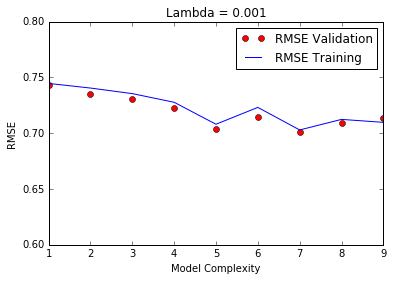

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.01


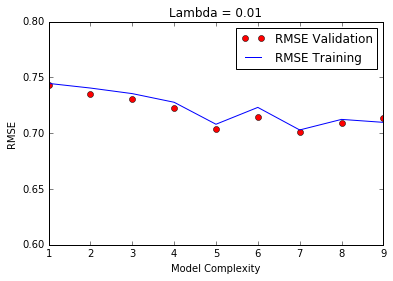

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.1


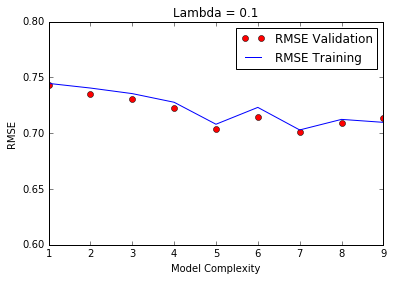

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.5


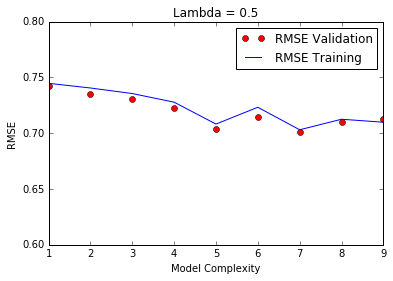

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  1


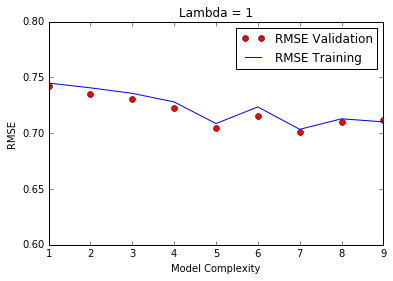

In [34]:
for lamda in sorted(error_matrix_syn['closed_form']['train']):
    print "Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ = ", lamda
    plot_data(error_matrix_syn['closed_form']['validation'][lamda],error_matrix_syn['closed_form']['train'][lamda], lamda, 'RMSE Validation', 'RMSE Training', [1, 9, 0.6, 0.8])

Let us inspect all the values of RMSE Training(Erms,t) and RMSE Validation(Erms,v) for different values of regularisation parameter and number of basis functions M, for all models trained using closed form solution on our synthetic dataset.

__Note that, we shall choose the model as the best fit, which has least RMSE Validation(Erms,v). As stated earlier, the test dataset has been secluded until this spot, and we shall only calculate the final model performnace on it.__

RMSE Training for different values of λ(column headers) and Number of basis Functions(row headers)


,0.001,0.01,0.1,0.5,1.0
1,0.789995,0.789995,0.789995,0.789995,0.789995
2,0.744618,0.744618,0.744621,0.744700,0.744919
3,0.740463,0.740463,0.740465,0.740513,0.740651
4,0.735468,0.735468,0.735470,0.735529,0.735696
5,0.727718,0.727718,0.727721,0.727799,0.728017
6,0.708025,0.708025,0.708032,0.708189,0.708624
7,0.723123,0.723123,0.723128,0.723236,0.723534
8,0.702904,0.702904,0.702911,0.703060,0.703471
9,0.712371,0.712371,0.712377,0.712517,0.712902
10,0.709717,0.709717,0.709723,0.709843,0.710176


RMSE Validation for different values of λ(column headers) and Number of basis Functions(row headers)


,0.001,0.01,0.1,0.5,1.0
1,0.785390,0.785390,0.785390,0.785391,0.785392
2,0.742942,0.742933,0.742846,0.742550,0.742359
3,0.735151,0.735149,0.735130,0.735093,0.735139
4,0.730700,0.730694,0.730638,0.730452,0.730353
5,0.722294,0.722289,0.722248,0.722138,0.722146
6,0.703701,0.703701,0.703702,0.703830,0.704219
7,0.714902,0.714898,0.714871,0.714853,0.715031
8,0.701029,0.701026,0.701003,0.701021,0.701277
9,0.709320,0.709327,0.709394,0.709779,0.710416
10,0.713768,0.713747,0.713543,0.712804,0.712203


### After reviewing the RMSE Validation for different values of M and λ, and from the plots above, we can see that the training model with M = 8 and λ = 0.1, has the best performance for fitting the given Synthetic dataset and has the least RMSE on Validation set = 0.701

### Hence, this is the model and the parameters that we shall choose as our solution. Let us print the performance metrics of the model and the final weights of the trained model.

__Now let us go ahead and measure the model performance on TEST DATA SET. The RMSE on Test set shall be reported as the performance of our linear regression model.__

In [40]:
lamda = 0.1
num_basis = 8
design_matrix_train_syn_closed, sigma_inv_syn_closed, rbf_centers_syn_closed = create_design_matrix_train_data(training_data_syn, training_labels_syn, lamda, num_basis)
weights_syn_closed, rmse_train_syn_closed= closed_form_solution_training_phase(design_matrix_train_syn_closed, sigma_inv_syn_closed, training_labels_syn, lamda, num_basis)
design_matrix_validation_syn_closed = create_design_matrix_data(valid_data_syn, sigma_inv_syn_closed, rbf_centers_syn_closed, num_basis)
rmse_validation_syn_closed = calculate_error(design_matrix_validation_syn_closed, weights_syn_closed, valid_labels_syn)
design_matrix_test_syn_closed = create_design_matrix_data(test_data_syn, sigma_inv_syn_closed, rbf_centers_syn_closed, num_basis)
rmse_test_syn_closed = calculate_error(design_matrix_test_syn_closed, weights_syn_closed, test_labels_syn)

In [41]:
print "Best fit Linear Regression Model using Closed Form Solution Performance: "
print "\n"
print "RMSE on Training Set: ", rmse_train_syn_closed 
print "\n"
print "RMSE on Validation Set: ", rmse_validation_syn_closed
print "\n"
print "RMSE on Test Set: ", rmse_test_syn_closed
print "\n"
print "Weights Vector(w) for the trained Model:\n", weights_syn_closed

Best fit Linear Regression Model using Closed Form Solution Performance: 


RMSE on Training Set:  0.702910964106


RMSE on Validation Set:  0.701002785416


RMSE on Test Set:  0.703795980591


Weights Vector(w) for the trained Model:
[ 0.77260372  8.79510525  5.00020789 -1.61916018 -4.78165888  1.10689493
  4.59794028  3.83249897]


### As we see, the Root Mean Square Error of our trained linear regression model using Closed Form Solution and Gaussian Basis Functions on Test Synthetic Dataset is 0.7038, for M = 8  and λ = 0.1


Now let us try finding the solution to the same Synthetic dataset, but this time, we shall be using Stochastic Gradient Descent Algorithm, for finding the weight vector(w) which give us the minimum RMSE value on Validation set.

### 4. Train a linear regression model on the synthetic dataset using Stochastic Gradient Descent (SGD)

### Stochastic Gradient Descent


In [43]:
lamda_values = [0.001, 0.01, 0.1, 0.5, 1]
for lamda in lamda_values:
    print "λ = ", lamda
    error_matrix_syn['sgd']['train'][lamda] = []
    error_matrix_syn['sgd']['validation'][lamda] = []
    for num_basis in range(1, 11):
        design_matrix_train_syn_sgd, sigma_inv_syn_sgd, rbf_centers_syn_sgd = create_design_matrix_train_data(training_data_syn, training_labels_syn, lamda, num_basis)
        weights_syn_sgd, rmse_train_syn_sgd, learning_rate_changes_syn, error_iteration_syn = stochastic_gradient_solution(design_matrix_train_syn_sgd, training_labels_syn, lamda, num_basis)
        design_matrix_validation_syn_sgd = create_design_matrix_data(valid_data_syn, sigma_inv_syn_sgd, rbf_centers_syn_sgd, num_basis)
        rmse_validation_syn_sgd = calculate_error(design_matrix_validation_syn_sgd, weights_syn_sgd, valid_labels_syn)
        error_matrix_syn['sgd']['train'][lamda].append(rmse_train_syn_sgd)
        error_matrix_syn['sgd']['validation'][lamda].append(rmse_validation_syn_sgd)

λ =  0.001
λ =  0.01
λ =  0.1
λ =  0.5
λ =  1


We have stored the model performance corresponding to each trained model, with unique combination of (M, λ) in the error_matrix_letor['sgd'] dictionary.

We shall now plot the model performance parameters, and shall study how the performance changes as the model complexity increases for different values of regularisation parameter.
This will enable us to choose the best trained model which fits the given Synthetic dataset optimally.

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.001


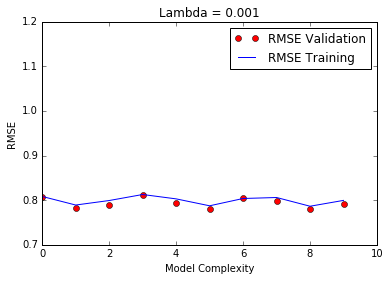

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.01


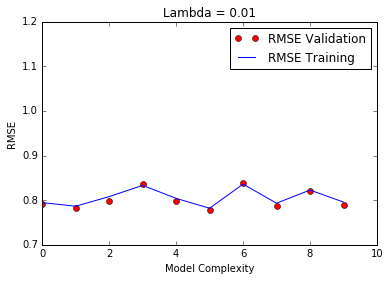

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.1


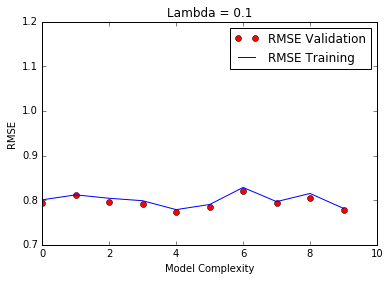

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  0.5


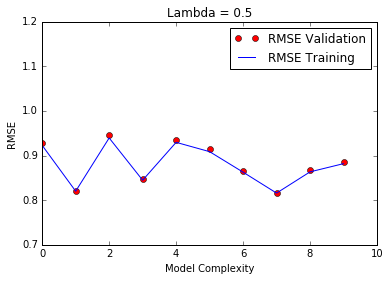

Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ =  1


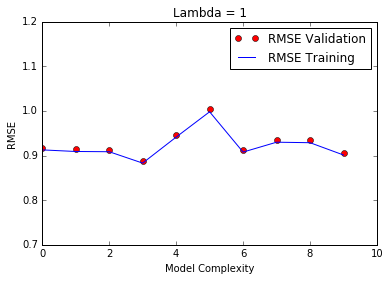

In [45]:
for lamda in sorted(error_matrix_syn['sgd']['train']):
    print "Plot for RMSE Validation across different number of Gaussian Basis Functions, for λ = ", lamda
    plot_data(error_matrix_syn['sgd']['validation'][lamda],error_matrix_syn['sgd']['train'][lamda], lamda, 'RMSE Validation', 'RMSE Training', [0, 10, 0.7, 1.2])

Let us inspect all the values of RMSE Training(Erms,t) and RMSE Validation(Erms,v) for different values of regularisation parameter and number of basis functions M.

__Note that, we shall choose the model as the best fit, which has least RMSE Validation(Erms,v). As stated earlier, the test dataset has been secluded until this spot, and we shall only calculate the final model performnace on it.__

RMSE Training for different values of λ(column headers) and Number of basis Functions(row headers)


,0.001,0.01,0.1,0.5,1.0
1,0.808289,0.794406,0.800734,0.922665,0.912619
2,0.789101,0.786424,0.811884,0.820089,0.909038
3,0.799173,0.807906,0.804233,0.939348,0.908506
4,0.812657,0.833139,0.798764,0.844681,0.883033
5,0.802881,0.803998,0.778793,0.929516,0.941210
6,0.787374,0.781912,0.790235,0.908654,0.997962
7,0.803729,0.835950,0.828459,0.862706,0.907712
8,0.805949,0.793218,0.796714,0.815847,0.929838
9,0.786405,0.822663,0.815007,0.863394,0.928718
10,0.799475,0.795726,0.781492,0.881797,0.901134


RMSE Validation for different values of λ(column headers) and Number of basis Functions(row headers)


,0.001,0.01,0.1,0.5,1.0
1,0.807596,0.791723,0.793241,0.927985,0.917612
2,0.783044,0.782879,0.811470,0.820488,0.913894
3,0.790153,0.798987,0.796782,0.945136,0.913352
4,0.811797,0.837017,0.792415,0.846825,0.886935
5,0.793641,0.798795,0.772676,0.935015,0.947084
6,0.780725,0.778536,0.785404,0.913541,1.005256
7,0.804422,0.837841,0.819499,0.865713,0.912524
8,0.798391,0.785994,0.794393,0.815871,0.935408
9,0.781238,0.820497,0.805144,0.866458,0.934236
10,0.790502,0.790217,0.778111,0.885763,0.905729


### After reviewing the RMSE Validation for different values of M and λ, and from the plots above, we can see that the training model with M = 5 and λ = 0.1, has the best performance for fitting the given Synthetic dataset using Stochastic Gradient Descent and has the least RMSE on Validation set = 0.7727

### Hence, this is the model and the parameters that we shall choose as our solution. Let us print the performance metrics of the model and the final weights of the trained model.

__Now let us go ahead and measure the model performance on TEST DATA SET. The RMSE on Test set shall be reported as the performance of our linear regression model using Stochastic Gradient Descent on LeToR Dataset.__

In [67]:
lamda = 0.1
num_basis = 5
design_matrix_train_syn_sgd, sigma_inv_syn_sgd, rbf_centers_syn_sgd = create_design_matrix_train_data(training_data_syn, training_labels_syn, lamda, num_basis)
weights_syn_sgd, rmse_train_syn_sgd, learning_rate_changes_syn_sgd, error_iteration_syn_sgd = stochastic_gradient_solution(design_matrix_train_syn_sgd, training_labels_syn, lamda, num_basis)
design_matrix_validation_syn_sgd = create_design_matrix_data(valid_data_syn, sigma_inv_syn_sgd, rbf_centers_syn_sgd, num_basis)
rmse_validation_syn_sgd = calculate_error(design_matrix_validation_syn_sgd, weights_syn_sgd, valid_labels_syn)
design_matrix_test_syn_sgd = create_design_matrix_data(test_data_syn, sigma_inv_syn_sgd, rbf_centers_syn_sgd, num_basis)
rmse_test_syn_sgd = calculate_error(design_matrix_test_syn_sgd, weights_syn_sgd, test_labels_syn)

In [68]:
print "Best fit Linear Regression Model using Stochastic Gradient Descent(SGD) Performance Metrics: "
print "\n"
print "RMSE on Training Set: ", rmse_train_syn_sgd 
print "\n"
print "RMSE on Validation Set: ", rmse_validation_syn_sgd
print "\n"
print "RMSE on Test Set: ", rmse_test_syn_sgd
print "\n"
print "Weights Vector(w) for the trained Model:\n", weights_syn_sgd

Best fit Linear Regression Model using Stochastic Gradient Descent(SGD) Performance Metrics: 


RMSE on Training Set:  0.790984233768


RMSE on Validation Set:  0.785747840733


RMSE on Test Set:  0.789271504073


Weights Vector(w) for the trained Model:
[ 0.96941244  0.41271343 -0.52450814  0.53908908 -0.11550907]


### As we see, the Root Mean Square Error of our trained linear regression model using Stochastic Gradient Descent Algorithm and Gaussian Basis Functions on Test Dataset is 0.7892, for M = 5  and λ = 0.1.

Now, as the last step of the solution, let us verify the hypothesis we stated regarding the Learning rate(η). 

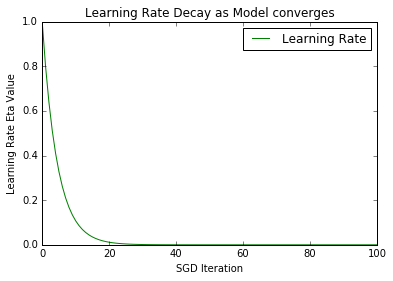

In [66]:
plt.plot(learning_rate_changes_syn_sgd, 'g-', label='Learning Rate')
plt.axis([0, 100, 0, 1])
plt.ylabel('Learning Rate Eta Value')
plt.xlabel('SGD Iteration')
plt.title('Learning Rate Decay as Model converges')
l = plt.legend()
plt.show()

##### As can be verified from the Learning rate plot, its a decay plot and the learning rate(η) keeps on decreasing as the iterations proceed and we move closer towards the optimal solution.

Let us also plot the Training error as the number of iterations of the SGD algorithm increase. 

The intuition as we have learnt for Stochastic Gradient Descent Algorithm is that, initially the training error would be high and will have drastic fluctuations, as the algorithm is making predicions based on a few datapoints it has seen. 

As the iterations increase, the model becomes more robust and the rate of change of error reduces.

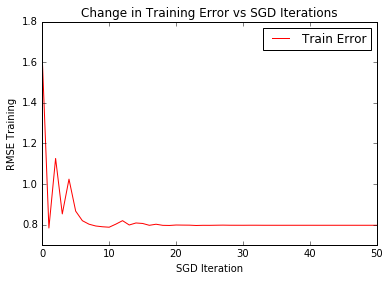

In [216]:
plt.plot(error_iteration_syn_sgd, 'r-', label='Train Error')
plt.axis([0, 50, 0.7, 1.8])
plt.ylabel('RMSE Training')
plt.xlabel('SGD Iteration')
plt.title('Change in Training Error vs SGD Iterations')
l = plt.legend()
plt.show()

## Conclusion

On comparing the performance of the two methods we observe that for the closed form solution approach, we need to calculate NxM design matrix for each values of M. So that becomes approximately NxM2. However for small number of features M is a constant and run time will be in the order of N.

In comparison, for stochastic gradient descent approach we need to calculate nxM order design matrix. (n<N, where n is the value when the error change becomes minimal). However if we have a design matrix already computed the runtime is of the order nxM. Computing the whole design matrix, or saving the already computed values iteratively results in a much faster implementation of the gradient descent approach and will be much faster than closed form solution approach as n<N, for n being the value when we stop the weight matrix iterations when the error change become significantly small. 

Thus we have successfully applied Closed form Solution approach and Stochastic Gradient Descent algorithm for training a linear regression model on the LeToR dataset and the synthetic dataset.